In [1]:
exp_numb=2
frame_width=640
frame_height=480
fps=90
number_of_frames_to_record=3100
background_chunk=100 #I want to use 500 frames for recording the background
preset_json_file="d415paramset_640480.json"
grand_frame=int(exp_numb*(number_of_frames_to_record-background_chunk))
min_range=0
max_range=1000
data_chunk_size=100
box_size=192 #this is how big I want my video to be (200 by 200) #YOU WILL GET ERRORS IF YOU'RE BOX IS BIGGER THAN THE MIDDLE OF THE IMAGE (x or y)
dpi=80

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import sys
sys.path.append('/usr/local/lib')

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.colors as mcol
import matplotlib.cm as cm
import math
import imageio
import gc
import time
import pandas as pd
import json
import pyrealsense2 as rs
import cv2
from scipy import stats
from scipy import ndimage #for finding com
from scipy.misc import imsave
from itertools import cycle
cycol = cycle('bgrcmk') #here I'm generating a list of colors I can plot

In [5]:
#!mkdir dlc_Movie

In [6]:
# Enabling Advanced Mode

DS5_product_ids = ["0AD1", "0AD2", "0AD3", "0AD4", "0AD5", "0AF6", "0AFE", "0AFF", "0B00", "0B01", "0B03", "0B07"]

def find_device_that_supports_advanced_mode() :
    ctx = rs.context()
    ds5_dev = rs.device()
    devices = ctx.query_devices();
    for dev in devices:
        if dev.supports(rs.camera_info.product_id) and str(dev.get_info(rs.camera_info.product_id)) in DS5_product_ids:
            if dev.supports(rs.camera_info.name):
                print("Found device that supports advanced mode:", dev.get_info(rs.camera_info.name))
            return dev
    raise Exception("No device that supports advanced mode was found")

try:
    dev = find_device_that_supports_advanced_mode()
    advnc_mode = rs.rs400_advanced_mode(dev)
    print("Advanced mode is", "enabled" if advnc_mode.is_enabled() else "disabled")

    # Loop until we successfully enable advanced mode
    while not advnc_mode.is_enabled():
        print("Trying to enable advanced mode...")
        advnc_mode.toggle_advanced_mode(True)
        # At this point the device will disconnect and re-connect.
        print("Sleeping for 5 seconds...")
        time.sleep(5)
        # The 'dev' object will become invalid and we need to initialize it again
        dev = find_device_that_supports_advanced_mode()
        advnc_mode = rs.rs400_advanced_mode(dev)
        print("Advanced mode is", "enabled" if advnc_mode.is_enabled() else "disabled")

    
except Exception as e:
    print(e)
pass

Found device that supports advanced mode: Intel RealSense D415
Advanced mode is enabled


In [7]:
# Loading presaved parameters 
# If I have another set of parameters I'd like to use already in the json format, I can skip the previous three blocks of code
    
with open(preset_json_file) as json_data: #Json file to be loaded #NOTE im using default NOT the json that I just created above
    starting_params = json.load(json_data)
    starting_params=str(starting_params).replace("'", '\"') #IF YOU DON't DO THIS IT WILL NOT WORK with the librealsense sdk
    print(starting_params)

{"aux-param-autoexposure-setpoint": "400", "aux-param-colorcorrection1": "0.461914", "aux-param-colorcorrection10": "-0.553711", "aux-param-colorcorrection11": "-0.553711", "aux-param-colorcorrection12": "0.0458984", "aux-param-colorcorrection2": "0.540039", "aux-param-colorcorrection3": "0.540039", "aux-param-colorcorrection4": "0.208008", "aux-param-colorcorrection5": "-0.332031", "aux-param-colorcorrection6": "-0.212891", "aux-param-colorcorrection7": "-0.212891", "aux-param-colorcorrection8": "0.68457", "aux-param-colorcorrection9": "0.930664", "aux-param-depthclampmax": "65536", "aux-param-depthclampmin": "0", "aux-param-disparityshift": "0", "controls-autoexposure-auto": "True", "controls-autoexposure-manual": "33000", "controls-color-autoexposure-auto": "True", "controls-color-autoexposure-manual": "166", "controls-color-backlight-compensation": "0", "controls-color-brightness": "0", "controls-color-contrast": "50", "controls-color-gain": "64", "controls-color-gamma": "300", "co

In [8]:
#Experimental Loop
file = open('pythondepthdata.bin', 'a+b') #open a file for apending binary data
# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, frame_width, frame_height, rs.format.z16, fps)
#config.enable_stream(rs.stream.color, frame_width, frame_height, rs.format.bgr8, fps)
advnc_mode.load_json(starting_params) #this is where I start with the Defualt Json
# Start streaming
cfg = pipeline.start(config)
dev = cfg.get_device()
depth_sensor = dev.first_depth_sensor()
#depth_sensor.set_option(rs.option.visual_preset, 2)
#hff = rs.hole_filling_filter()    
#hff.set_option(rs.option.holes_fill, 1)
sf=rs.spatial_filter()
#sf.set_option()

iteration = 0;
#preset = 0;
#preset_name = '';
tick=0; #keeping track of the number of loops the experiment has gone through 


In [9]:
start_of_loop=time.time()
with open('pythondepthdata.bin','ab') as binarydata: #While the file called "pythonedpthdata.bin" is open for appending binary, 
    try:
        while tick<number_of_frames_to_record: #aiming for 2000 frames
            tick=tick+1 
            
            # Wait for a coherent pair of frames: depth and color
            frames = pipeline.wait_for_frames()
            depth_frame = frames.get_depth_frame()
            depth_frame = sf.process(depth_frame); #apply a hole filling filter

            #color_frame = frames.get_color_frame()

            #iteration = iteration + 1
            #if iteration > 100:
               #preset = preset + 1
               #iteration = 0
               #range = depth_sensor.get_option_range(rs.option.visual_preset)
               #preset = preset % range.max
               #depth_sensor.set_option(rs.option.visual_preset, preset)
               #preset_name = depth_sensor.get_option_value_description(rs.option.visual_preset, preset)
        
            # Convert images to numpy arrays
            depth_image = np.asanyarray(depth_frame.get_data())
            #color_image = np.asanyarray(color_frame.get_data())
            depth_image.tofile(binarydata) #save data as binarydata (specified by the with open as line)
            
            if tick==background_chunk:
                output=input("please insert object to record and enter YYMMDD_exp#  ")
        
            # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
            #depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, None, 0.5, 0), cv2.COLORMAP_JET)

            # Stack both images horizontally
            #images = np.hstack((color_image, depth_colormap))
        
            #font = cv2.FONT_HERSHEY_SIMPLEX
            #cv2.putText(images, preset_name,(60,80), font, 4,(255,255,255),2,cv2.LINE_AA) 

            # Show images
            #cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
            #cv2.imshow('RealSense', images)
            #cv2.waitKey(1)
            with open('depth_ts.txt', 'a') as ts:
                ts.write('%s\n' %rs.frame.get_timestamp(frames)) #write time stamp float as a string to a new line

    finally:

        # Stop streaming
        pipeline.stop()
        end_of_loop=time.time() #end timer
        print("Time Elapsed = ", end_of_loop - start_of_loop)
        serialized_string = advnc_mode.serialize_json() #getting the current parameters as a serialized string
        as_json_object = json.loads(serialized_string) #loading the json object from the serialized string
        json_used_in_experiment = str(as_json_object).replace("'", '\"') #converting object into string that can be printed
        print("Final Parameters = ", json_used_in_experiment)

please insert object to record and enter YYMMDD_exp#  2
Time Elapsed =  74.19922685623169
Final Parameters =  {"aux-param-autoexposure-setpoint": "400", "aux-param-colorcorrection1": "0.461914", "aux-param-colorcorrection10": "-0.553711", "aux-param-colorcorrection11": "-0.553711", "aux-param-colorcorrection12": "0.0458984", "aux-param-colorcorrection2": "0.540039", "aux-param-colorcorrection3": "0.540039", "aux-param-colorcorrection4": "0.208008", "aux-param-colorcorrection5": "-0.332031", "aux-param-colorcorrection6": "-0.212891", "aux-param-colorcorrection7": "-0.212891", "aux-param-colorcorrection8": "0.68457", "aux-param-colorcorrection9": "0.930664", "aux-param-depthclampmax": "65536", "aux-param-depthclampmin": "0", "aux-param-disparityshift": "0", "controls-autoexposure-auto": "True", "controls-autoexposure-manual": "33000", "controls-color-autoexposure-auto": "True", "controls-color-autoexposure-manual": "166", "controls-color-backlight-compensation": "0", "controls-color-brig

In [10]:
#get background frames
background_frames = np.fromfile('pythondepthdata.bin', dtype=np.uint16, count=(int(frame_height*frame_width*background_chunk*16))).reshape(-1, frame_height, frame_width)[0:background_chunk] #A highly efficient way of reading binary data with a known data-type, as well as parsing simply formatted text files. Data written using the tofile method can be read using this function.

0

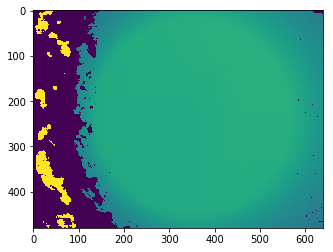

In [11]:
plt.imshow(background_frames[6])
plt.clim(0,1000)
gc.collect()

In [12]:
#Making a movie for Deep Lab Cut
number_of_frames=number_of_frames_to_record
video_width=frame_width
video_height=frame_height
backgroundmean=np.mean(background_frames, axis=0) #may be better to use median
backgroundvariance=np.var(background_frames, axis=0)



for batch_number in range(int((number_of_frames-background_chunk)/data_chunk_size)):
    
    
    current_frame=0
    
    gc.collect()
     
    frames = np.fromfile('pythondepthdata.bin', dtype=np.uint16).reshape(-1, frame_height, frame_width)[background_chunk+(batch_number*data_chunk_size):background_chunk+(batch_number*data_chunk_size)+data_chunk_size]
    for f in range(int(data_chunk_size)):
        
        #FRAME TO PROCESS
        frame_of_interest=frames[current_frame] 
        
        #IF PIXEL ISN'T SIGNIFICANTLY DIFFERENT FROM THE BACKGROUND THEN DROP IT
        backgroundmultiplier=np.abs(frame_of_interest - backgroundmean) - (15*np.sqrt(backgroundvariance)) 

        #WE EXPECT POSITIVE VALUES FOR HIGH DIFFERENCES make them stay by multiplying by 1
        backgroundmultiplier[backgroundmultiplier>0]=1
        #WE EXPECT NEGATIVE VALUES FOR SMALL OR NO DIFFERENCE probably just noise, get rid of them by multiplying by 0
        backgroundmultiplier[backgroundmultiplier<=0]=0
       
        # SUBTRACT BACKGROUND BY MULTIPLYING INSIGNIFIACNT FRAMES BY ZERO
        frame_of_interest_backgroundsubtracted=(np.multiply(frame_of_interest,backgroundmultiplier)).astype('uint8') #IMWRITE TAKES UINT8
        frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted>max_range]=0
        frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted<=min_range]=0
        
        #################################################################
        #ALGORITHIM FOR FINDING THE CENTER OF THE OBJECT (TO CROP THE PLOT) (this actually works better than any built in function I've tried)
        #basically, the row and column with the most non zero values should be the center
        
        winningrow=0
        winningcountr=video_width
        for rowpixels in range(0,video_height):
            currentcountr=np.count_nonzero(frame_of_interest_backgroundsubtracted[rowpixels,:]==0)
            if currentcountr<winningcountr:
                winningcountr=currentcountr
                winningrow=rowpixels

        winningcolumn=0
        winningcountc=video_height
        for columnpixels in range(0,video_width):
            currentcountc=np.count_nonzero(frame_of_interest_backgroundsubtracted[:,columnpixels]==0)
            if currentcountc<winningcountc:
                winningcountc=currentcountc
                winningcolumn=columnpixels

        if winningrow<(box_size/2):
            winningrow=(int(box_size/2))
        if winningrow>(video_height-box_size/2):
            winningrow=int(video_height-box_size/2-1)
        if winningcolumn<(box_size/2):
             winningcolumn=(int(box_size/2))
        if winningcolumn>(video_width-box_size/2):
            winningcolumn=int(video_width-box_size/2-1)
        
        ####################################################################

        #THIS IS THE FRAME NUMBER (I WILL COMBINE MANY RUNS SO I'M OUTPUTTING THE MASTER FRAME NUMBER)
        fplusd=int(f+grand_frame+(batch_number*data_chunk_size))
        print(fplusd)
       

        # THIS IS HOW I SHOULD SAVE ARRAYS SO THEY COME OUT AS 192 by 192 FOR IMAGE ANALYSIS (IT'S SMALLER!)
        imageio.imwrite('/home/rockwell/Real_Sensible_Moseq/data_acquisition/dlc_Movie/dlc_frame_%06d.png'%fplusd,frame_of_interest_backgroundsubtracted[winningrow-int(box_size/2):winningrow+int(box_size/2),winningcolumn-int(box_size/2):winningcolumn+int(box_size/2)])

        current_frame=current_frame+1
        
        
    

6000
6001
6002
6003
6004
6005
6006
6007
6008
6009
6010
6011
6012
6013
6014
6015
6016
6017
6018
6019
6020
6021
6022
6023
6024
6025
6026
6027
6028
6029
6030
6031
6032
6033
6034
6035
6036
6037
6038
6039
6040
6041
6042
6043
6044
6045
6046
6047
6048
6049
6050
6051
6052
6053
6054
6055
6056
6057
6058
6059
6060
6061
6062
6063
6064
6065
6066
6067
6068
6069
6070
6071
6072
6073
6074
6075
6076
6077
6078
6079
6080
6081
6082
6083
6084
6085
6086
6087
6088
6089
6090
6091
6092
6093
6094
6095
6096
6097
6098
6099
6100
6101
6102
6103
6104
6105
6106
6107
6108
6109
6110
6111
6112
6113
6114
6115
6116
6117
6118
6119
6120
6121
6122
6123
6124
6125
6126
6127
6128
6129
6130
6131
6132
6133
6134
6135
6136
6137
6138
6139
6140
6141
6142
6143
6144
6145
6146
6147
6148
6149
6150
6151
6152
6153
6154
6155
6156
6157
6158
6159
6160
6161
6162
6163
6164
6165
6166
6167
6168
6169
6170
6171
6172
6173
6174
6175
6176
6177
6178
6179
6180
6181
6182
6183
6184
6185
6186
6187
6188
6189
6190
6191
6192
6193
6194
6195
6196
6197
6198
6199


7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740
7741
7742
7743
7744
7745
7746
7747
7748
7749
7750
7751
7752
7753
7754
7755
7756
7757
7758
7759
7760
7761
7762
7763
7764
7765
7766
7767
7768
7769
7770
7771
7772
7773
7774
7775
7776
7777
7778
7779
7780
7781
7782
7783
7784
7785
7786
7787
7788
7789
7790
7791
7792
7793
7794
7795
7796
7797
7798
7799
7800
7801
7802
7803
7804
7805
7806
7807
7808
7809
7810
7811
7812
7813
7814
7815
7816
7817
7818
7819
7820
7821
7822
7823
7824
7825
7826
7827
7828
7829
7830
7831
7832
7833
7834
7835
7836
7837
7838
7839
7840
7841
7842
7843
7844
7845
7846
7847
7848
7849
7850
7851


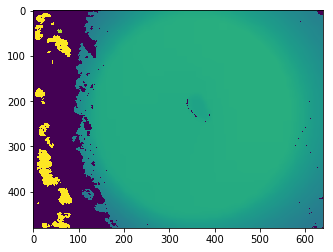

In [13]:
plt.imshow(frame_of_interest)
plt.clim(0,1000)

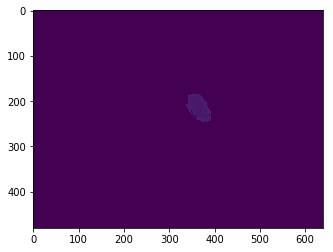

In [14]:
plt.imshow(frame_of_interest_backgroundsubtracted)
plt.clim(0,1000)

In [15]:
#background subtracted Movie as an MP4! Perfect data input for leap
#!ffmpeg -i /home/rockwell/Real_Sensible_Moseq/data_acquisition/dlc_Movie/dlc_frame_%06d.png -c:v libx264 -vf fps=90 -pix_fmt yuv420p -r 90 dlc_out.mp4

In [16]:
bye=input("Clear data at the end?         :")


Clear data at the end?         :yes


In [17]:
if bye == "yes" or "YES" or "Yes" or "Y" or "y" or "sure" or "1" or "k" or "K" or "bye" or "Bye" or "ye" or "yah" or "yup" or "ok" or "okay" :
# MAKE SURE TO REMOVE THIS IF YOU WANT TO SAVE DATA
    !rm pythondepthdata.bin 
    !rm depth_ts.txt 
#rm -r d415_Movie/
#rm -r dlc_Movie/